# **Stroke Prediction using KNN Model**

In this classification task, the **objective** is to predict the presence of a stroke (labeled as 1) or the absence of a stroke (labeled as 0) for a given patient. 

Features such as gender, age, hypertension, heart disease, marital status, work type, residence type, average glucose level, BMI, and smoking status are the input for the prediction.

# Import the libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

# Load the dataset

In [2]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# EDA

In [3]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Remove the first column, "ID," since it doesn't contribute valuable information.

In [4]:
df = df.drop('id', axis=1)

**Check for duplicates**

In [5]:
duplicates = df[df.duplicated()]
duplicates

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


No duplicates in the dataset.

**Check for missing values**

In [6]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


There are 201 entries with missing values for BMI. Let's eliminate the rows from the DataFrame, df, where BMI is not available.

In [7]:
df.dropna(subset=['bmi'], inplace=True)

**Check the data types**

In [8]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

The categorical values are: 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'

**Map numerical values to the categorical variables**

1. Gender

In [9]:
Unique_gender = df['gender'].unique()
print("Categories are:", Unique_gender)

Categories are: ['Male' 'Female' 'Other']


Let's identify how many patients are labeled as "Other."

In [10]:
category_counts = df['gender'].value_counts()
category_counts

gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

There is only one patient labeled as 'Other.' Let's exclude that row from the dataset.

In [11]:
df.drop(df[df['gender'] == 'Other'].index, inplace=True)

In [12]:
#mapping
gender_mapping={'Female': 0,'Male': 1}
df['gender']=df['gender'].map(gender_mapping)

2. ever_married

In [13]:
Unique_ever_married = df['ever_married'].unique()
print("Categories are:", Unique_ever_married)

Categories are: ['Yes' 'No']


In [14]:
category_counts = df['ever_married'].value_counts()
category_counts

ever_married
Yes    3204
No     1704
Name: count, dtype: int64

In [15]:
#mapping
ever_married_mapping={'Yes': 0,'No': 1}
df['ever_married']=df['ever_married'].map(ever_married_mapping)

3. work_type

In [16]:
Unique_work_type = df['work_type'].unique()
print("Categories are:", Unique_work_type)

Categories are: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


In [17]:
category_counts = df['work_type'].value_counts()
category_counts

work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: count, dtype: int64

In [18]:
#mapping
work_type_mapping={'Private': 0,'Self-employed': 1, 'children': 2,'Govt_job':3, 'Never_worked': 4 }
df['work_type']=df['work_type'].map(work_type_mapping)

4. Residence_type

In [19]:
Unique_Residence_type = df['Residence_type'].unique()
print("Categories are:", Unique_Residence_type)

Categories are: ['Urban' 'Rural']


In [20]:
category_counts = df['Residence_type'].value_counts()
category_counts

Residence_type
Urban    2490
Rural    2418
Name: count, dtype: int64

In [21]:
#mapping
Residence_type_mapping={'Urban': 0,'Rural': 1}
df['Residence_type']=df['Residence_type'].map(Residence_type_mapping)

5. smoking_status

In [22]:
Unique_smoking_status = df['smoking_status'].unique()
print("Categories are:", Unique_smoking_status)

Categories are: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [23]:
category_counts = df['smoking_status'].value_counts()
category_counts

smoking_status
never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: count, dtype: int64

In [24]:
#mapping
smoking_status_mapping={'never smoked': 0,'Unknown': 1, 'formerly smoked': 2,'smokes':3}
df['smoking_status']=df['smoking_status'].map(smoking_status_mapping)

The categorical variables have now been transformed into numerical variables.

**Correlation matrix of variables.**

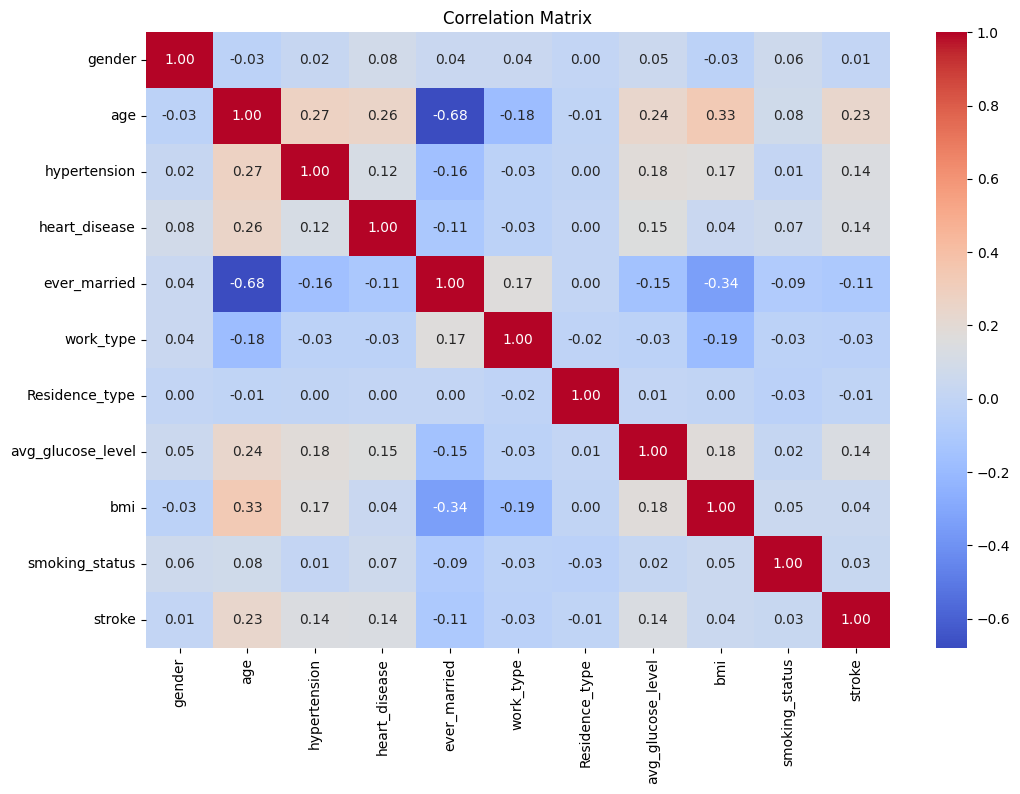

In [25]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Marital status and age display a significant positive correlation, which indicates potential collinearity. To mitigate this collinearity, I plan to eliminate one of the variables, specifically "ever_married."

**Understand the target variable, stroke.**

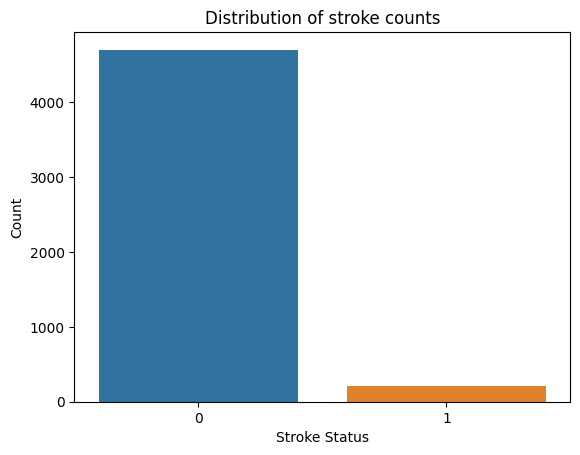

Count of each unique value in 'counts':
stroke
0    4699
1     209
Name: count, dtype: int64


In [26]:
sns.countplot(x='stroke', data=df)
plt.title('Distribution of stroke counts')
plt.xlabel('Stroke Status')
plt.ylabel('Count')
plt.show()

counts = df['stroke'].value_counts()

# Display the count of each unique value
print("Count of each unique value in 'counts':")
print(counts)

Class imbalance is noted.

# Feature selection

In [27]:
x = df.drop(['ever_married','stroke'], axis=1)
y = df.stroke

# Standardize the data

In [28]:
sc = StandardScaler()
x = sc.fit_transform(x)

To address the issue of class imbalance, apply Synthetic Minority Over-sampling Technique (SMOTE).

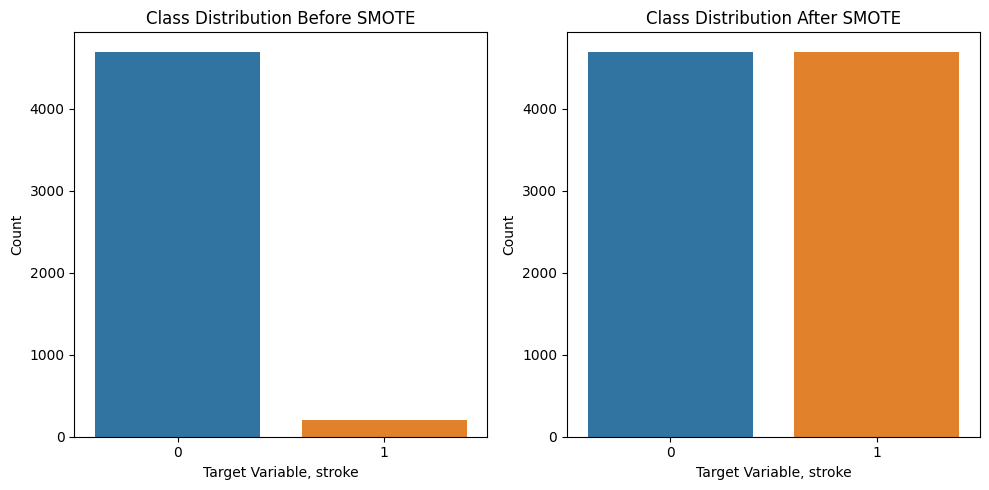

In [29]:
# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Before SMOTE
sns.countplot(x=y, ax=axes[0])
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Target Variable, stroke')
axes[0].set_ylabel('Count')

# After SMOTE
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Target Variable, stroke')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Initialize the KNN classifier

In [30]:
#  Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [31]:
# Assuming you have these variables already defined in your code
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (7518, 9)
Shape of x_test: (1880, 9)
Shape of y_train: (7518,)
Shape of y_test: (1880,)


In [32]:
# Initialize KNN classifier with default parameters
knn_model = KNeighborsClassifier()

# Train the KNN model on the training set
knn_model.fit(x_train, y_train)

# Predict on the training set
y_train_pred = knn_model.predict(x_train)

Evaluate and print results

In [33]:
# Evaluate the KNN model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

# Print training results
print("KNN Model - Training Metrics:")
table_train = PrettyTable()
table_train.field_names = ["Metric", "Value"]
table_train.add_row(["Accuracy", round(train_accuracy, 3)])
table_train.add_row(["AUC", round(train_auc, 3)])
table_train.add_row(["F1 Score", round(train_f1, 3)])
table_train.add_row(["Recall", round(train_recall, 3)])
print(table_train)
print("=" * 50)

# Predict on the testing set
y_test_pred = knn_model.predict(x_test)

# Evaluate the KNN model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# Print testing results
print("\nKNN Model - Testing Metrics:")
table_test = PrettyTable()
table_test.field_names = ["Metric", "Value"]
table_test.add_row(["Accuracy", round(test_accuracy, 3)])
table_test.add_row(["AUC", round(test_auc, 3)])
table_test.add_row(["F1 Score", round(test_f1, 3)])
table_test.add_row(["Recall", round(test_recall, 3)])
print(table_test)
print("=" * 50)

# Cross-validation on the training set
cv_scores = cross_val_score(knn_model, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("KNN Model - Cross-Validation Scores:")
print("CV Mean Accuracy: {:.3f}".format(round(cv_scores.mean(), 3)))
print("CV Standard Deviation: {:.3f}".format(round(cv_scores.std(), 3)))
print("=" * 50)

KNN Model - Training Metrics:
+----------+-------+
|  Metric  | Value |
+----------+-------+
| Accuracy | 0.934 |
|   AUC    | 0.934 |
| F1 Score | 0.937 |
|  Recall  | 0.994 |
+----------+-------+

KNN Model - Testing Metrics:
+----------+-------+
|  Metric  | Value |
+----------+-------+
| Accuracy | 0.916 |
|   AUC    | 0.914 |
| F1 Score | 0.923 |
|  Recall  | 0.992 |
+----------+-------+
KNN Model - Cross-Validation Scores:
CV Mean Accuracy: 0.895
CV Standard Deviation: 0.007


# Note

In summary, the model seems to perform well on both the training and testing datasets, with high accuracy, AUC, F1, and recall. The cross-validation results also indicate good generalization performance. However, to enhance the model's performance even further, let's do hyperparameter tuning. 

# Hyperparameter tuning for the classifier

In [34]:
# Define the parameter grid 
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [35]:
# Initialize the classifier
knn_model = KNeighborsClassifier()

In [36]:
# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [37]:
# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters for KNN:")
table_hyperparams = PrettyTable()
table_hyperparams.field_names = ["Parameter", "Value"]
for param, value in knn_grid_search.best_params_.items():
    table_hyperparams.add_row([param, value])
print(table_hyperparams)
print("Best Accuracy for KNN: {:.4f}".format(knn_grid_search.best_score_))
print("=" * 50)

Best Hyperparameters for KNN:
+-------------+----------+
|  Parameter  |  Value   |
+-------------+----------+
| n_neighbors |    3     |
|      p      |    1     |
|   weights   | distance |
+-------------+----------+
Best Accuracy for KNN: 0.9288


In [38]:
# Train the KNN model with the best hyperparameters on the training set
best_knn_model = KNeighborsClassifier(**knn_grid_search.best_params_)
best_knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [39]:
# Predict on the training set
y_train_pred = best_knn_model.predict(x_train)

# Predict on the testing set
y_test_pred = best_knn_model.predict(x_test)

In [40]:
# Evaluate the best KNN model on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

In [41]:
# Print testing results
print("Best KNN Model - Testing Metrics:")
table_testing = PrettyTable()
table_testing.field_names = ["Metric", "Value"]
table_testing.add_row(["Accuracy", round(test_accuracy, 3)])
table_testing.add_row(["AUC", round(test_auc, 3)])
table_testing.add_row(["F1 Score", round(test_f1, 3)])
table_testing.add_row(["Recall", round(test_recall, 3)])
print(table_testing)
print("=" * 50)

Best KNN Model - Testing Metrics:
+----------+-------+
|  Metric  | Value |
+----------+-------+
| Accuracy | 0.951 |
|   AUC    |  0.95 |
| F1 Score | 0.953 |
|  Recall  | 0.992 |
+----------+-------+


In [42]:
# Cross-validation 
cv_scores = cross_val_score(best_knn_model, x_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Best KNN Model - Cross-Validation Scores:")
print("CV Mean Accuracy: {:.4f}".format(round(cv_scores.mean(), 3)))
print("CV Standard Deviation: {:.4f}".format(round(cv_scores.std(), 3)))
print("=" * 50)

Best KNN Model - Cross-Validation Scores:
CV Mean Accuracy: 0.9290
CV Standard Deviation: 0.0070


# confusion matrix for the test model (tuned KNN classifier)

In [43]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing):")
print(conf_matrix)


Confusion Matrix (Testing):
[[837  85]
 [  8 950]]


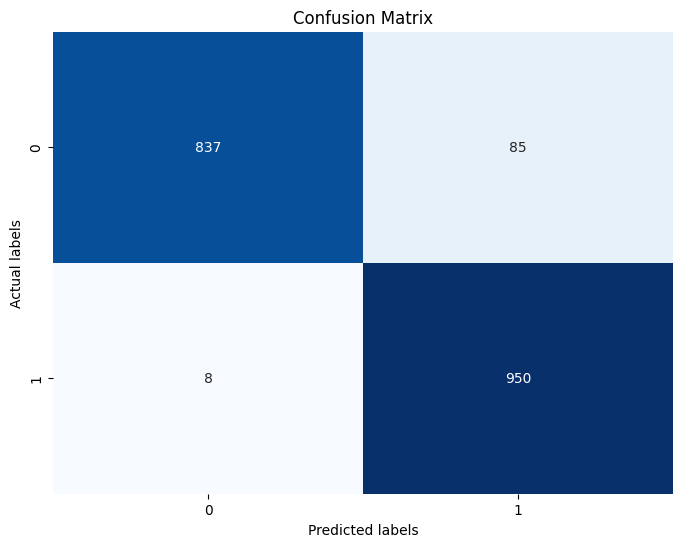

In [44]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()


# **Summary**

Hyperparameter tuning process has significantly enhanced the KNN model's accuracy and generalization performance.